# Fitting CNN and PCA to Anvil and Ant Image Data

Now that I've successfully visualized the images, the next steps are to preprocess the images so that I can fit the pixel data to a neural network and perform PCA on them. I'll explain each of the steps in more detail below, but the main goal of the neural network is to train a model that can distinguish between drawing classes. The main goal of PCA is to see if there are certain columns that account for the majority of the spread in the data. With that knowledge, we might be able to see if there are certain characteristics of each image category's pixels that are distinguishing factors. 

I have an older computer, so I will only perform this project on 10_000 images of ants and anvils. My computer took at least 30 minutes to complete the tasks toward the end of the notebook.

> A lot of the code in this notebook takes a while to run on slower machines. Feel free to import a progress bar (i.e. tqdm_notebook). 

In [1]:
#Run cell twice to remove future warnings from keras

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool  #spreads computer tasks to speed up processes
from sklearn.model_selection import train_test_split  
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import pickle
import quickdraw
from quickdraw import QuickDrawData
from quickdraw import QuickDrawDataGroup
from sklearn.decomposition import PCA

Using TensorFlow backend.
C:\Users\kwama\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kwama\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kwama\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kwama\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Loading Images of Anvils

In [2]:
anvils = QuickDrawDataGroup('anvil', max_drawings = 10_000)
print(anvils.drawing_count)


loading anvil drawings
load complete
10000


Shows up to 10,000 images of anvils that can be referenced with the index parameter.

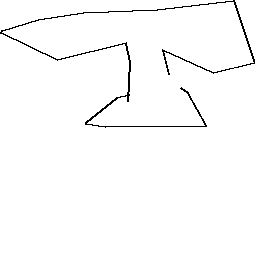

In [4]:
anvils.get_drawing(index=7002).get_image()

Saves anvil images to disk by using their key_id.

In [5]:
for i in range(5):
    anvil = anvils.get_drawing(index=i)
    filename = f'anvil_{anvil.key_id}'
    anvil.image.save(f'Images/{filename}.jpg')

Lists images saved to disk

In [6]:
os.listdir('Images')[:5]

['anvil_4505235412221952.jpg',
 'anvil_4508750339637248.jpg',
 'anvil_4509087947554816.jpg',
 'anvil_4512441700450304.jpg',
 'anvil_4513264534814720.jpg']

Creates filepath variable that references path to image file

In [7]:
filepath = 'Images/anvil_4675518521671680.jpg'

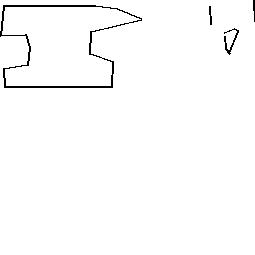

In [8]:
Image.open(filepath)

This function converts images to grayscale matrices.

In [3]:
def get_grayscale_array(filepath):
    
    #calls and opens image
    img = Image.open(filepath)  
    
    #resizes image pixels into 3D matrix
    arr = np.array(list(img.getdata())).reshape(255, 255, 3)  
    
    #turns image to black and white by applying weights to RBG colors in matrix
    gray = np.dot(arr[...,:3], [0.2989, 0.5870, 0.1140])
    
    return gray

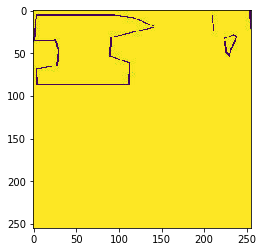

In [10]:
plt.imshow(get_grayscale_array(filepath))

In [11]:
# Shows the gray_scale matrix for image
get_grayscale_array(filepath)

array([[253.9746, 250.9749, 254.9745, ..., 250.9749,   2.9997,   0.    ],
       [254.9745, 253.9746, 237.9762, ..., 250.9749,   2.9997,   0.    ],
       [249.975 , 252.9747, 254.9745, ..., 250.9749,   2.9997,   0.    ],
       ...,
       [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
       [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
       [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745]])

# Preprocessing

After calling the drawings, I need to transform the pixel description matrices from RGB to black and white. Right now there are 3 numbers (R, G, B) representing a single pixel, but after transforming there will only be one. This saves memory and the time it would take to fit a CNN and perform PCA on the dataset.

### Anvils

Load 1000 images and save their filename

In [11]:
for i in range(1_000):
    anvil = anvils.get_drawing(index=i)
    filename = f'anvil_{anvil.key_id}'
    anvil.image.save(f'Images/{filename}.jpg')

This next code block iterates the grayscale function over each image in the Images directory and stores matrices as a dataframe

In [ ]:
def img_to_matrix_to_dataframe(file):
    
    #Collects image filepaths to iterate over
    filepath = f'Images/{file}'

    #Create dataframe row for each image, where each pixel is a column
    image_pixels = pd.DataFrame(get_grayscale_array(filepath).reshape(255 * 255,)/ 255).T
#     image_pixels.columns = [f'pixel_{i+1}' for i in range(255*255)]

    #Create label column
    image_pixels['label'] = 'anvil'
    
    return image_pixels

In [17]:
list_of_img_matrices = [img_to_matrix_to_dataframe(each) for each in os.listdir('Images/')]
#combines list of dataframe rows together
df = pd.concat(list_of_img_matrices, ignore_index=True)

#Create label column and clarify column names
df.columns = [f'pixel_{i+1}' for i in range(255*255)]
df['label'] = 'anvil'

df.head()

### Ants 

In [4]:
ants = QuickDrawDataGroup('ant', max_drawings = 10_000)
print(ants.drawing_count)

loading ant drawings
load complete
10000


In [5]:
for i in range(1_000):
    ant = ants.get_drawing(index=i)
    filename = f'ant_{ant.key_id}'
    ant.image.save(f'Images_ants/{filename}.jpg')

In [6]:
def img_to_matrix_to_dataframe(file):
    
    #Collects image filepaths to iterate over
    filepath = f'Images_ants/{file}'

    #Create dataframe row for each image, where each pixel is a column
    image_pixels = pd.DataFrame(get_grayscale_array(filepath).reshape(255 * 255,)/ 255).T
    
    return image_pixels

In [ ]:
list_of_img_matrices = [img_to_matrix_to_dataframe(each) for each in os.listdir('Images_ants/')]

#combines list of dataframe rows together
df_ants = pd.concat(list_of_img_matrices, ignore_index=True)

#Create label column and clarify column names
df_ants.columns = [f'pixel_{i+1}' for i in range(255*255)]

df_ants['label'] = 'ant'

df_ants.head()

In [3]:
df.shape

(1000, 65026)

In [4]:
df_ants.shape

(1000, 65026)

# Set up X and y

Our explanatory variables will be the pixels used to make each image, and the target variable will be the category of the image.

In [8]:
df = pd.read_csv('anvils.csv')
df_ants = pd.read_csv('ants.csv')

In [9]:
df.drop(columns = 'label', inplace = True)
df.columns = [f'pixel_{i+1}' for i in range(255*255)]
df['label'] = 'anvil'
df.head()

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_65017,pixel_65018,pixel_65019,pixel_65020,pixel_65021,pixel_65022,pixel_65023,pixel_65024,pixel_65025,label
0,0.999900,0.999900,0.9999,0.999900,0.9999,0.999900,0.999900,0.999900,0.999900,0.999900,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil
1,0.999900,0.999900,0.9999,0.999900,0.9999,0.999900,0.999900,0.999900,0.999900,0.999900,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil
2,0.960688,0.999900,0.9999,0.925398,0.9999,0.999900,0.960688,0.999900,0.999900,0.964609,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil
3,0.050975,0.945004,0.9999,0.980294,0.9999,0.941082,0.999900,0.964609,0.976373,0.999900,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil
4,0.999900,0.999900,0.9999,0.999900,0.9999,0.999900,0.999900,0.999900,0.999900,0.995979,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil


In [10]:
antvil_df = pd.concat([df, df_ants])
antvil_df.head()

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_65017,pixel_65018,pixel_65019,pixel_65020,pixel_65021,pixel_65022,pixel_65023,pixel_65024,pixel_65025,label
0,0.999900,0.999900,0.9999,0.999900,0.9999,0.999900,0.999900,0.999900,0.999900,0.999900,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil
1,0.999900,0.999900,0.9999,0.999900,0.9999,0.999900,0.999900,0.999900,0.999900,0.999900,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil
2,0.960688,0.999900,0.9999,0.925398,0.9999,0.999900,0.960688,0.999900,0.999900,0.964609,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil
3,0.050975,0.945004,0.9999,0.980294,0.9999,0.941082,0.999900,0.964609,0.976373,0.999900,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil
4,0.999900,0.999900,0.9999,0.999900,0.9999,0.999900,0.999900,0.999900,0.999900,0.995979,...,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,anvil


In [11]:
X = antvil_df.drop('label', axis = 1).values
y = antvil_df['label'].map(lambda x: 1 if x == 'anvil' else 0)

In [12]:
y.value_counts()

1    1000
0    1000
Name: label, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [14]:
# Reshape each image to be 255 x 255 x 1.
X_train = X_train.reshape(X_train.shape[0], 255, 255, 1)
X_test = X_test.reshape(X_test.shape[0], 255, 255, 1)

# Fitting Combined Ant and Anvil Data to a Convolutional Neural Network

In [15]:
cnn_model = Sequential()

# Add a convolutional layer.

cnn_model.add(Conv2D(filters = 6,            # number of filters
                     kernel_size = 15,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(255, 255, 1))) # shape of input (image)

cnn_model.add(MaxPooling2D(pool_size=(10,10))) # dimensions of region of pooling

cnn_model.add(Conv2D(16,
                     kernel_size=15,
                     activation='relu'))

cnn_model.add(MaxPooling2D(pool_size=(10,10)))

cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons and L2 regularizer
cnn_model.add(Dense(128, activation='relu',
             kernel_regularizer=regularizers.l2(0.01)))

#Add dropout layer for regularization
cnn_model.add(Dropout(0.5)) # refers to nodes in the first hidden layer


# Add a final layer with 10 neurons.
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [16]:
#Add early stopping to stop when accuracy drops twice in a row
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

# Fit model on training data
history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=10,
                        validation_data=(X_test, y_test),
                        epochs=3,
                        verbose=1,
                        callbacks=[early_stop])

Train on 1500 samples, validate on 500 samples
Epoch 1/3
1500/1500 [==============================] - 858s 572ms/step - loss: 0.8306 - acc: 0.5940 - val_loss: 0.7261 - val_acc: 0.4940
Epoch 2/3
1500/1500 [==============================] - 810s 540ms/step - loss: 0.5376 - acc: 0.7853 - val_loss: 0.3852 - val_acc: 0.8500
Epoch 3/3
1500/1500 [==============================] - 821s 547ms/step - loss: 0.3020 - acc: 0.9127 - val_loss: 0.2326 - val_acc: 0.9400


## CNN Results

As we can see from the results above this cell, the CNN performed amazing well when regularization was added to it. 
> * A train accuracy score of .913
* A test accuracy score of .940
* A train loss score of.302
* A test loss score of .233

These results let me know that my CNN is not overfitting to the data, is accurately modeling the data, and is learning about the data very well with room for even more improvement. The CNN loss graph below lets us know that we can increase the number of epochs for the CNN and get even better results because our loss has not flattened out, meaning there is still more that the CNN can learn about the data.

Loss is telling me how much the neural network is learning per epoch. Accuracy is telling me how many drawings the neural network is correctly classifying. 

In [17]:
# Check out the model summary.
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 241, 241, 6)       1356      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        21616     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

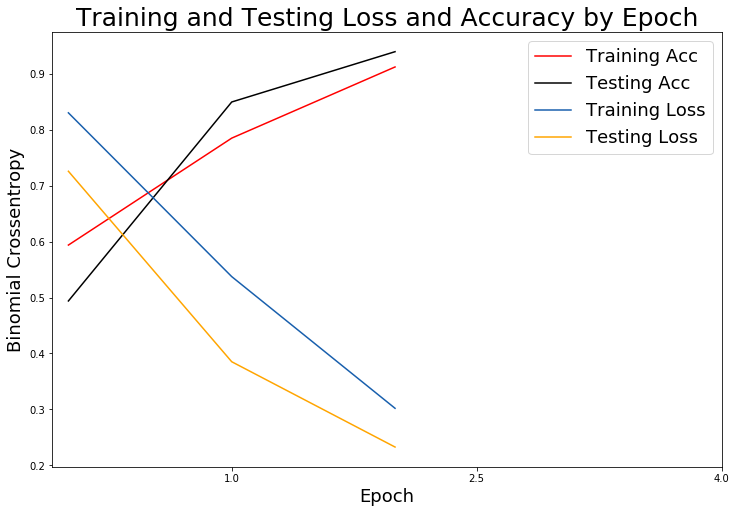

In [19]:
# Check out our train loss and test loss over epochs.
train_acc = history.history['acc']
test_acc = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc, label='Training Acc', color='red')
plt.plot(test_acc, label='Testing Acc', color='black')


# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([1, 2, 3, 4])

plt.legend(fontsize = 18);

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binomial Crossentropy', fontsize = 18)
plt.xticks([1, 2, 3, 4])

plt.legend(fontsize = 18);

In [20]:
# Evaluate model on test data.
cnn_score = cnn_model.evaluate(X_test,
                               y_test,
                               verbose=1)

cnn_labels = cnn_model.metrics_names

500/500 [==============================] - 116s 232ms/step


In [21]:
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')

CNN loss  : 0.23263660955429077
CNN acc   : 0.9399999995231628


# Applying PCA to Combined Ant and Anvil Dataset

My last task is to apply principal component analysis to my dataset. This required me to remove the column that stated whether or not a row of pixels belonged to an ant or an anvil, but once that was done I was able to see if there were any meaningful column combinations that attributed for the majority of the spread in the data. It's important to note that there are over 60,000 columns in this dataset, so the possibility of discovering that 3 or maybe even 1 column accounts for 70% of the spread of that data could be very interesting-- albeit unlikely. The first principal component represents the columns that account for the largest spread of the data, second row accounts for the second largest spread, and so on. In order to truly understand the results given by PCA, I had to plot them because I am dealing with pixels.

In [23]:
pca = PCA()
pca.fit(antvil_df.drop(columns = 'label'))
pca.transform(antvil_df.drop(columns = 'label'))

array([[ 3.83232569e+00, -6.08819497e+00, -8.61924013e-01, ...,
         2.35315098e-02, -2.60946985e-02,  1.83527239e-14],
       [-2.42641245e+00,  1.03421740e+00,  2.92080063e+00, ...,
        -9.89983148e-03, -1.50991558e-01,  1.70787863e-14],
       [-4.33040040e+00, -2.52214669e+00,  4.61407058e+00, ...,
        -5.66808484e-01, -2.11630418e-01,  1.44975178e-14],
       ...,
       [-5.02722977e-01, -2.63987492e+00, -1.79627575e+00, ...,
        -1.11315034e-01, -1.21031290e-02,  1.97016882e-14],
       [ 3.52520726e+00, -4.86497279e+00, -3.12004924e+00, ...,
        -7.29454047e-02,  1.43444024e-02,  1.66735115e-14],
       [-1.01427129e+00, -2.98493920e+00, -2.52236882e+00, ...,
        -1.67654899e-01,  8.40962900e-03,  1.27905499e-14]])

In [24]:
pca_antvil = pd.DataFrame(pca.components_,
             columns=antvil_df.drop(columns = 'label').columns,
            index=[f'PCA_{n}' for n in range(1,2001)])

In [25]:
pca_antvil.head()

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_65016,pixel_65017,pixel_65018,pixel_65019,pixel_65020,pixel_65021,pixel_65022,pixel_65023,pixel_65024,pixel_65025
PCA_1,0.003474,0.004223,0.003593,0.003492,0.004265,0.004464,0.005085,0.005603,0.005245,0.006060,...,-0.000021,-0.000022,0.000028,0.000026,0.000026,0.000026,0.000025,0.000024,0.000026,0.000025
PCA_2,0.003559,0.002378,0.001890,0.001116,0.000786,0.000385,-0.000276,-0.000161,0.000412,-0.000082,...,0.000418,0.000415,0.000154,0.000147,0.000147,0.000147,0.000143,0.000134,0.000147,0.000144
PCA_3,0.000045,-0.002274,-0.004192,-0.004387,-0.005610,-0.005990,-0.006870,-0.006962,-0.007273,-0.008176,...,0.000132,0.000125,-0.000017,-0.000022,-0.000022,-0.000022,-0.000021,-0.000020,-0.000022,-0.000021
PCA_4,-0.007245,-0.005295,-0.004147,-0.003946,-0.002268,-0.002102,-0.001921,-0.001922,-0.003144,-0.003425,...,-0.000198,-0.000200,0.000081,0.000079,0.000079,0.000079,0.000077,0.000072,0.000079,0.000078
PCA_5,-0.002574,-0.003974,-0.003056,-0.003465,-0.005476,-0.004441,-0.004536,-0.005354,-0.004784,-0.005432,...,-0.000391,-0.000388,-0.000239,-0.000225,-0.000225,-0.000225,-0.000219,-0.000206,-0.000225,-0.000221


## PCA Results

After applying PCA to the antvil dataframe, it turns out that we can explain 8% of our data with 25 PCA components. Furthermore, each PCA component doesn't account for more than 1.2% of the spread in the data. Overall, that is much better than having to parse through over 65,000 columns. In fact, 25 components is a thousandth ($1/1000$) of the total number of features in the dataset! 

In order to truly understand what these components are explaining about our data, I need to visualize them. It's important to know how to interpret the images or "eigendoodles" that are you are going to see. 

Eigendoodles represent the variables the computer believes makes up the largest spread of the data. An example would be if given a bunch of images of beaches, images that had a bright spot in the corner vs had no bright spot in the corner would account for the largest spread in the data. Then maybe images that had a bunch of stuff at the top vs images that had a bunch of stup at the bottom would account for the next largest spread in the data. Eigendoodles tell us some thing and that thing's complete opposite with their representations.

In [37]:
np.cumsum(pca.explained_variance_ratio_)[:25]

array([0.01160167, 0.01960167, 0.0248581 , 0.0286759 , 0.03233782,
       0.03582828, 0.03909563, 0.04226405, 0.04518279, 0.04801882,
       0.05071298, 0.05331109, 0.05583067, 0.05827237, 0.0605904 ,
       0.06288248, 0.06510656, 0.067294  , 0.0694337 , 0.07146882,
       0.07348628, 0.07546358, 0.07740243, 0.07932999, 0.0812328 ])

This is the first PCA component, Z1. It appears to represent drawings that are on the top or bottom of the page. This accounts for 1.2% of the spread in the data. 

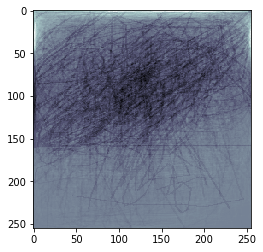

In [26]:
plt.imshow(pca_antvil.loc['PCA_1'].values.reshape(255, 255), cmap='bone')

This is the second PCA component, Z2. This component appears to represent drawings at the top 25% or bottom 75% of the page. 

It makes sense that this would account for the second highest spread in the data because for the most part, when you're doing any task, you either avoid the top of the page entirely, or you try to fit everything into the top of the page to avoid using a lot of space.

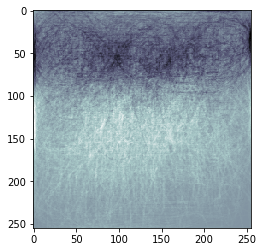

In [27]:
plt.imshow(pca_antvil.loc['PCA_2'].values.reshape(255, 255), cmap='bone')

This is the third PCA component, Z3. This component appears to represent drawings that are done with or without diagonal lines along the top of the page. 

This is a very interesting component because it could hint at the fact the handedness of mobile users. Maybe most people that drew the images were right handed, and started their images from the top right corner and finished at the middle left of the page. The component is open for interpretation. 


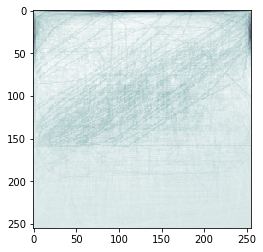

In [28]:
plt.imshow(pca_antvil.loc['PCA_3'].values.reshape(255, 255), cmap='bone')

The last few cells are more visualizations of the PCA components. Feel free to make your own interpretations for them, and to copy and paste the code and pick different components to replace the `['PCA_4]`. I hope you enjoy the great part of Principal Component Analysis: the interpretation and analysis. 

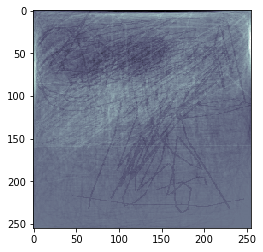

In [29]:
plt.imshow(pca_antvil.loc['PCA_4'].values.reshape(255, 255), cmap='bone')

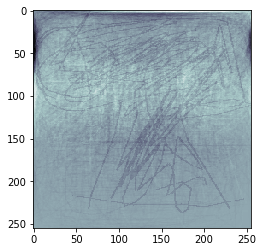

In [30]:
plt.imshow(pca_antvil.loc['PCA_5'].values.reshape(255, 255), cmap='bone')

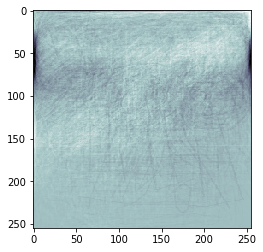

In [31]:
plt.imshow(pca_antvil.loc['PCA_6'].values.reshape(255, 255), cmap='bone')